In [1]:
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
emb_path = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/'
modelname = 'resnet50'
model_dir = os.path.join(emb_path,modelname)

In [4]:
manifolds_load = np.load(os.path.join(model_dir,'manifolds.npy'),allow_pickle=True)

In [5]:
P = 500
manifolds = []
for manifold in manifolds_load:
    manifolds.append(manifold[:P])
manifolds = np.stack(manifolds)

In [6]:
k = 5
m = 3

def fewshot_experiment(k,m):
    Xtrain = []
    Xtest = []
    idxs = np.random.choice(1000,k,replace=False)
    for a in idxs:
        perm = np.random.permutation(P)
        xtrain,xtest = np.split(manifolds[a][perm],(m,))
        Xtrain.append(xtrain)
        Xtest.append(xtest)
    Xtrain = np.stack(Xtrain)
    Xtest = np.stack(Xtest)

    prototypes = Xtrain.mean(1)
    dists = ((prototypes[:,None,None] - Xtest[None])**2).sum(-1)
    targets = np.tile(np.arange(k)[:,None],P-m)
    preds = dists.argmin(0)
    errs = (preds!=targets).mean(-1)
    
    return errs

In [30]:
k = 2 
ms = np.arange(1,6)
errs_all = []
for m in tqdm(ms):
    for _ in range(100):
        errs = fewshot_experiment(k,m)
        errs_all.append(errs)
errs_all = np.stack(errs_all).reshape(len(ms),-1,k)

100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


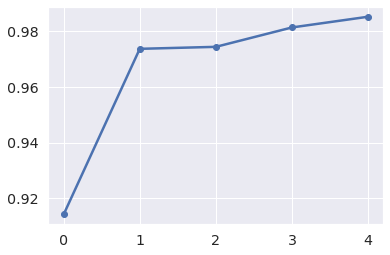

In [31]:
plt.plot(1-errs_all.mean((1,2)), 'o-')

# Jit

In [7]:
from jax import numpy as np
from jax import jit, random

In [8]:
key = random.PRNGKey(0)

In [9]:
manifolds = np.array(manifolds)

In [12]:
K = manifolds.shape[0]

def fewshot_experiment_jax(key,X,k,m):
    Xtrain = []
    Xtest = []
    for x in X:
        perm = random.permutation(key,P)
        xtrain,xtest = np.split(x[perm],(m,))
        Xtrain.append(xtrain)
        Xtest.append(xtest)
    Xtrain = np.stack(Xtrain)
    Xtest = np.stack(Xtest)

    prototypes = Xtrain.mean(1)
    dists = ((prototypes[:,None,None] - Xtest[None])**2).sum(-1)
    preds = dists.argmin(0)
    targets = np.tile(np.arange(k)[:,None],(P-m,))
    errs = (preds!=targets).mean(-1)
    
    return errs

fewshot_experiment_jit = jit(fewshot_experiment_jax,static_argnums=(2,3))

In [74]:
ks = np.arange(2,50,5) 
m = 5
ms = np.arange(1,6)
errs_all = {}
for k in tqdm(ks):
    errs_all[k] = []
    for _ in range(100):
        key,_ = random.split(key)
        idxs = random.randint(key,(k,),0,K)
        X = manifolds[idxs]
        errs = fewshot_experiment_jit(key,X,k,m)
        errs_all[k].append(errs)
# errs_all = np.stack(errs_all).reshape(len(ms),-1,k)

100%|██████████| 10/10 [18:45<00:00, 112.50s/it]


In [75]:
err_means = []
for k in ks:
    err_means.append(np.mean(np.stack(errs_all[k])))
err_means = np.stack(err_means)

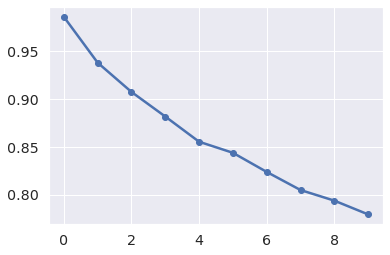

In [76]:
plt.plot(1-err_means, 'o-')

# Theory

In [13]:
from scipy.special import erfc
def H(x):
    return erfc(x/np.sqrt(2))/2

In [14]:
Rs = np.load(os.path.join(model_dir,'Rs.npy'))
Ds = (Rs**2).sum(-1)**2 / (Rs**4).sum(-1)
Us = np.load(os.path.join(model_dir,'Us.npy'))
x0s = np.load(os.path.join(model_dir,'centers.npy'))

In [15]:
from scipy.spatial.distance import pdist, squareform
dists = squareform(pdist(x0s))
dist_norm = dists / np.sqrt((Rs**2).mean(-1)[:,None])

In [16]:
# csa_all = np.load(os.path.join(model_dir,'center_subspace_a.npy'))
# csb_all = np.load(os.path.join(model_dir,'center_subspace_b.npy'))
# ss_all = np.load(os.path.join(model_dir,'subspace_subspace.npy'))

In [17]:
from scipy.stats import mvn

def kway_theory(idxs,m,k):
    pred_errs = []
    for a in idxs:
        Sigma = []
        mu = []
        for b in idxs[idxs!=a]:
            for c in idxs[idxs!=a]:
                dx0b = x0s[a] - x0s[b]
                dx0c = x0s[a] - x0s[c]
                csa = (Rs[a]**2*(Us[a]@dx0b)*(Us[a]@dx0c)).mean() / (Rs[a]**2).mean()**2

                sigma = 1/Ds[a]/m + 1/(2*Ds[a]*m**2) + csa

                if b==c:
                    sigma += (Rs[b]**2).mean()/(Rs[a]**2).mean()/(2*Ds[b]*m**2)
                    csb = ((Rs[b]*(Us[b]@dx0b))**2).mean() / (Rs[a]**2).mean()**2 / m
                    sigma += csb
                    cosphi = Us[a]@Us[b].T
                    ss = (cosphi**2*Rs[a][:,None]**2*Rs[b]**2).sum() / (Rs[a]**2).sum()**2 / m
                    sigma += ss

                    mean = 1/2*((x0s[a] - x0s[b])**2).sum() / (Rs[a]**2).mean()
                    mean += 1/2*((Rs[b]**2).sum()/(Rs[a]**2).sum() - 1)/m
                    mu.append(mean)
                Sigma.append(sigma)
        Sigma = np.stack(Sigma).reshape(k-1,k-1)
        mu = np.stack(mu)

        pred_err = 1 - mvn.mvnun(np.zeros(k-1), np.ones(k-1)*1e10,mu,Sigma)[0]
        pred_errs.append(pred_err)

    return np.stack(pred_errs)

In [24]:
%%timeit 
fewshot_experiment_jit(key,X,k,m)

904 µs ± 75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [49]:
k = 3
m = 5
ntest = 50
navg = 5000
ms = np.arange(1,6)
errs_all = []
pred_errs_all = []
for _ in tqdm(range(ntest)):
    key,_ = random.split(key)
    idxs = random.choice(key,K,(k,),replace=False)
    pred_errs = kway_theory(idxs,m,k)
    pred_errs_all.append(pred_errs)
    X = manifolds[idxs]
    
    for _ in range(navg):
        key,_ = random.split(key)
        errs = fewshot_experiment_jit(key,X,k,m)
        errs_all.append(errs)
    
errs_all = np.stack(errs_all).reshape(ntest,navg,k)
pred_errs_all = np.stack(pred_errs_all)
err_means = np.stack(errs_all).reshape(ntest,navg,k).mean(1)
err_stds = np.stack(errs_all).reshape(ntest,navg,k).std(1)

100%|██████████| 50/50 [06:55<00:00,  8.31s/it]


In [50]:
from scipy.special import erfc, erfcinv
def H(x):
    return erfc(x/np.sqrt(2))/2

def Hinv(z):
    return erfcinv(2*z)*np.sqrt(2)

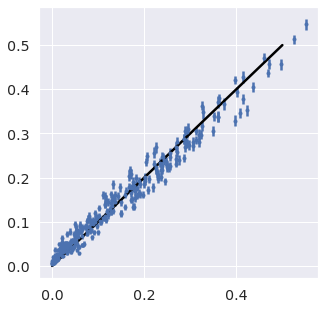

In [21]:
plt.figure(figsize=(5,5))

plt.errorbar(pred_errs_all.ravel(),err_means.ravel(),err_stds.ravel()/np.sqrt(navg)*3,fmt='.')

plt.plot([0,0.5],[0,0.5], c='black')

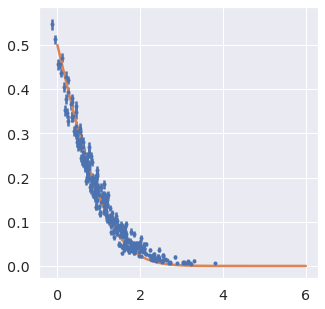

In [20]:
plt.figure(figsize=(5,5))

plt.errorbar(Hinv(pred_errs_all.ravel()),err_means.ravel(),err_stds.ravel()/np.sqrt(navg)*3,fmt='.')

# plt.plot([0,0.5],[0,0.5], c='black')
xx = np.linspace(0,6,1000)
plt.plot(xx,H(xx))

## Scaling

In [67]:
ks = np.arange(2,10)
m = 5
ntest = 5000
navg = 100
ms = np.arange(1,6)
errs_all = []
pred_errs_all = []

err_means = []
err_stds = []
err_pred_means = []
for k in tqdm(ks):
    errs_all = []
    pred_errs_all = []
    for _ in range(ntest//k//(k-1)):
        key,_ = random.split(key)
        idxs = random.choice(key,K,(k,),replace=False)
        pred_errs = kway_theory(idxs,m,k)
        pred_errs_all.append(pred_errs)
        X = manifolds[idxs]

        for _ in range(navg):
            key,_ = random.split(key)
            errs = fewshot_experiment_jit(key,X,k,m)
            errs_all.append(errs)
            
    errs_all = np.stack(errs_all)
    err_means.append(errs_all.mean())
    err_stds.append(errs_all.std())
    err_pred_means.append(np.stack(pred_errs_all).mean())

# errs_all = np.stack(errs_all).reshape(len(ks),ntest,navg,k)
# pred_errs_all = np.stack(pred_errs_all)
# err_means = np.stack(errs_all).reshape(len(ks),ntest,navg,k).mean(2)
# err_stds = np.stack(errs_all).reshape(len(ks),ntest,navg,k).std(2)

100%|██████████| 8/8 [50:59<00:00, 382.48s/it]  


In [68]:
err_means = np.stack(err_means)
err_stds = np.stack(err_stds)

In [73]:
from scipy import stats

def plot_CI(x,y,c,fmt,alpha=1):
    plt.plot(x,y.mean(-1), fmt, c=c,alpha=alpha)
    CImin,CImax = stats.t.interval(0.95, len(y),
                     loc=y.mean(-1), scale=stats.sem(y,axis=-1))
    plt.fill_between(x,CImin,CImax,color=c, alpha=0.2)

In [78]:
CImin,CImax = stats.t.interval(0.95, ntest*navg, loc=err_means, scale=err_stds/np.sqrt(ntest*navg))

/home/bsorsch/.jax/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [2 3 4 5 6 7 8 9] in fill_betweenx(). This will become an error two minor releases later.
  


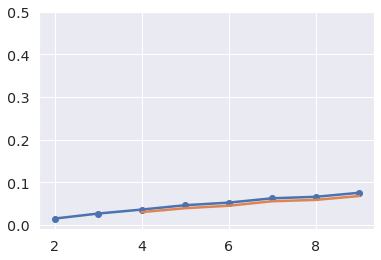

In [79]:
plt.plot(ks,err_means, 'o-')
plt.fill_between(ks,CImin,CImax, 'o-',alpha=0.2)
plt.plot(ks,err_pred_means)
plt.ylim([-0.01,0.5]);

/home/bsorsch/.jax/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [2 3 4 5 6 7 8 9] in fill_betweenx(). This will become an error two minor releases later.
  


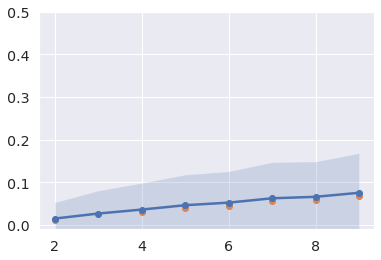

In [72]:
plt.plot(ks,err_means, 'o-')
plt.fill_between(ks,err_means+err_stds,err_means-err_stds, 'o-',alpha=0.2)
plt.plot(ks,err_pred_means)
plt.ylim([-0.01,0.5]);